본 분석은 Numeric timeseries data와 Unstructured timeseries data를 혼합하여 미래를 예측하는 전형적인 분석 방식이다.
이하 분석 방법과 알고리즘은 이번 코로나 상황에서 우리나라 입국자 수를 예측하는데 뿐만아니라 
일반화 하여 뉴스 정보를 포함한 금융분야의 각종 지수를 예측하는데도 효과적으로 사용 될 수 있을 것으로 기대한다.


<b>1. Forecast with numeric timeseries data</b>
   <br>먼저 로밍등록자 추세에 대해 1D Convolution에 의한 regression으로 입국자를 추정한다.

<b>2. Forecast with unstructured timeseries data</b>
   <br>news를 doc2vec으로 vector화 하여 Convolution에 의한 regression으로 입국자를 추정한다.

<b>3. Forecast with combined numeric timeseries and unstructured timeseries data</b>
   <br>마지막으로 두개의 feature group을 합친 알고리즘에 의해 입국자를 추정한다.

로밍등록자 정보는 과거 추세를 잘 설명할 것이나, 예측력은 떨어질 듯..치
news에 의한 추정은 과거 추세 설명력도 떨어지고 예측력도 로밍등록자 Case보다는 떨어지겠지만 미래 예측적인 측면에서는 정형(수치) 시계열 추정보다는 좋을 듯...



1. Forecast with numeric timeseries data<br>
  1.1 Roaming Data의 load<br>
 	1.2 Roaming Data에 대한 EDA
 		1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산
 		1.2.2 입국자(로밍등록자) 추세 chart 확인
 	1.3 Roaming Data의 전처리
 		1.3.1 iso 별로 재배열
 		1.3.2 2주 (14일) 평균 추세 추가.
 		1.3.3 Trainingset의 구성
 	1.4 CNN model 구성 
 	1.5 model training
 		1.5.1 model training
 		1.5.2 학습에 대한 mean_absolute_error 확인.
 		1.5.3 trainset에 의한 과거 data의 예측 입국자 count 
 		1.5.4 과거 Data에서 실등록자 count와 예측 count의 비교 
 	1.6  향후 15일 예측
 		1.6.1 testset (마지막 30일)의 inference
 		1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출




In [2]:
# 1. Forecast with numeric timeseries data
# 1.1 Roaming Data의 load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#공개된 Roaming Dataset을 읽고, 중간 중간 나온것을 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm = pd.concat([rm1, rm2], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
217800,20200401,vn,20200330,20200401,3
217801,20200401,vn,20200331,20200331,20
217802,20200401,vn,20200331,20200401,6
217803,20200401,vn,20200401,20200401,45


In [3]:
# 1.2 Roaming Data에 대한 EDA
# 1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산

ar = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ar['date'] =  ar.index.astype('object')
#date column을 datetime 으로 casting 한다.
ar['date'] =  pd.to_datetime(ar['date'], format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ar

,count,date
arrival,,
20191031,91,2019-10-31
20191101,36,2019-11-01
20191102,120,2019-11-02
20191103,159,2019-11-03
20191104,179,2019-11-04
...,...,...
20200424,711,2020-04-24
20200425,463,2020-04-25
20200426,447,2020-04-26


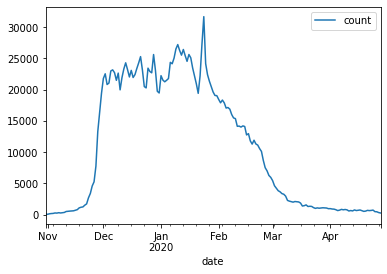

In [4]:
# 1.2.2 입국자(로밍등록자) 추세 chart 확인
ar.plot(x='date',y='count')

In [5]:
# 1.3 Roaming Data의 전처리
# 1.3.1 iso 별로 재배열

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
  if date == row[0][0]:
    pass
  else:
    if not r is None:
      rows.append(r)
    r = {}

  r['arrival'] = row[0][0]
  r[row[0][1]] = row[1][0]
  date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,tp,vu,zw,rs,tk,ug,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447


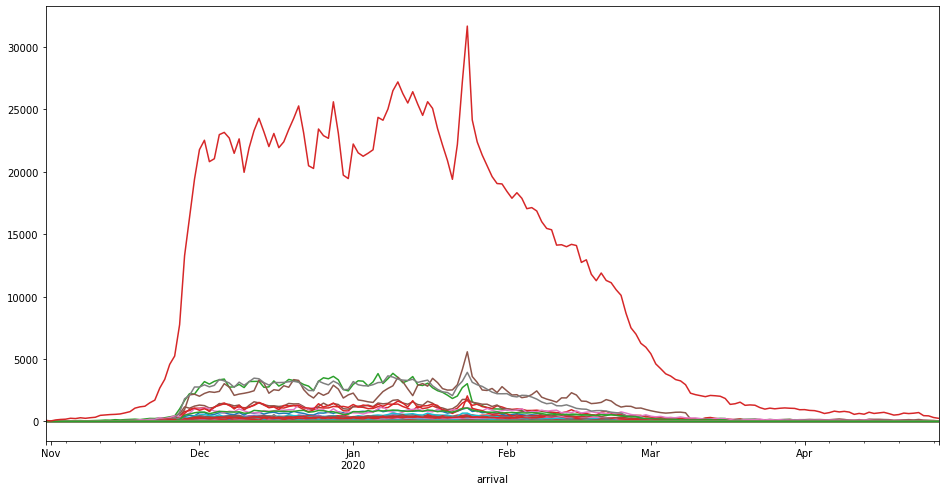

In [6]:
ds_iso.plot(legend=False,figsize=(16,8))

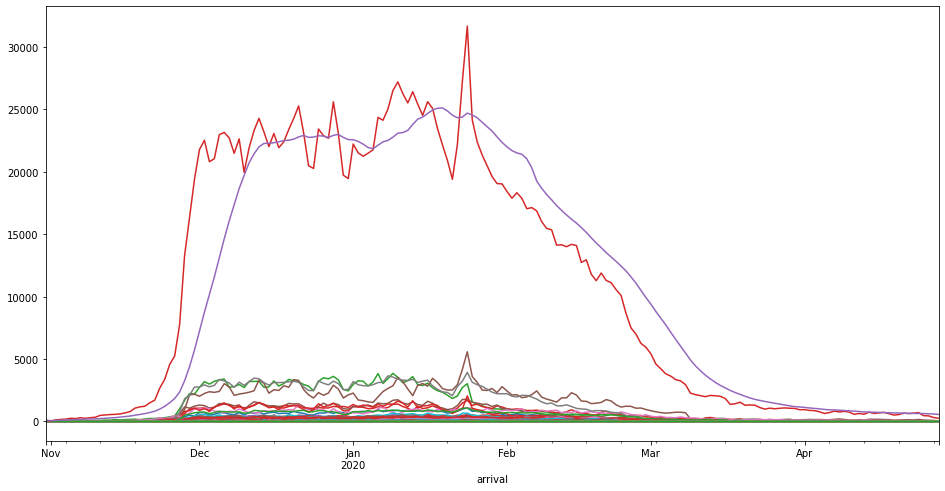

In [7]:
# 1.3.2 2주 (14일) 평균 추세 추가.
raw_ds = ds_iso.copy()
raw_ds['arrival_14ma'] = raw_ds['total'].rolling(window=14, min_periods=0).mean()
raw_ds.plot(legend=False,figsize=(16,8))

In [0]:
# 1.3.3 Trainingset의 구성

# Time-series CNN을 적용하기 위한 전처리
# 1D Convolution을 적용하기 위해..

import numpy as np

# window를 30일로 설정 -> 그냥 잡은 수치
window = 30
#입력 feature 개수.
size = len(raw_ds.columns) - 1 # totoal column 제외
#향후 15일 예측
forecast_days = 15


train_org_y = raw_ds['total'].to_numpy()
data = (raw_ds.drop(columns=['total'])).to_numpy()

train_x = []
train_y = []

for i in range(data.shape[0]-window-forecast_days + 1):
    sub_x = []
    for j in range(window):
        sub_x.append(data[i+j,:])
    train_x.append(sub_x)

    sub_y = []
    for z in range(forecast_days):
        sub_y.append(train_org_y[i + window + z])
    train_y.append(sub_y)

#train_x ,train_y의 준비
train_x = np.asarray(train_x)
train_x = train_x.reshape(-1,window,size)
train_y = np.asarray(train_y)

test_x = data[data.shape[0]-window:data.shape[0],:]

In [9]:
#train_x ,train_y의 내용 확인.
train_x, train_x.shape, train_y, train_y.shape, test_x, test_x.shape

(array([[[3.00000000e+00, 3.00000000e+00, 2.00000000e+01, ...,
          0.00000000e+00, 0.00000000e+00, 9.10000000e+01],
         [0.00000000e+00, 0.00000000e+00, 6.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 6.35000000e+01],
         [0.00000000e+00, 0.00000000e+00, 2.60000000e+01, ...,
          0.00000000e+00, 0.00000000e+00, 8.23333333e+01],
         ...,
         [7.20000000e+01, 1.21000000e+02, 1.00200000e+03, ...,
          0.00000000e+00, 0.00000000e+00, 2.35085714e+03],
         [1.20000000e+02, 1.44000000e+02, 1.68200000e+03, ...,
          0.00000000e+00, 0.00000000e+00, 3.25900000e+03],
         [1.41000000e+02, 1.56000000e+02, 2.22900000e+03, ...,
          0.00000000e+00, 0.00000000e+00, 4.38428571e+03]],
 
        [[0.00000000e+00, 0.00000000e+00, 6.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 6.35000000e+01],
         [0.00000000e+00, 0.00000000e+00, 2.60000000e+01, ...,
          0.00000000e+00, 0.00000000e+00, 8.23333333e+01],
       

In [10]:
# 1.4 CNN model 구성 

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,4, input_shape=(window, size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256))
model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae'])

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           89216     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 64)            32832     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 32)            

In [11]:
# 1.5 model training
# 1.5.1 model training

#학습 시작...
hist = model.fit(train_x, train_y, epochs=800,verbose=1)

Epoch 1/800
137/137 [==============================] - 6s 44ms/step - loss: 242781738.8029 - mae: 12072.9844
Epoch 2/800
137/137 [==============================] - 0s 279us/step - loss: 120567363.0949 - mae: 8420.4971
Epoch 3/800
137/137 [==============================] - 0s 254us/step - loss: 76935881.3431 - mae: 7117.4023
Epoch 4/800
137/137 [==============================] - 0s 263us/step - loss: 61300966.0438 - mae: 6002.5063
Epoch 5/800
137/137 [==============================] - 0s 254us/step - loss: 41539345.6350 - mae: 4965.0767
Epoch 6/800
137/137 [==============================] - 0s 272us/step - loss: 22820060.3066 - mae: 3371.9819
Epoch 7/800
137/137 [==============================] - 0s 261us/step - loss: 14163181.1898 - mae: 2535.8247
Epoch 8/800
137/137 [==============================] - 0s 282us/step - loss: 11465764.8467 - mae: 2228.1460
Epoch 9/800
137/137 [==============================] - 0s 324us/step - loss: 10439124.1551 - mae: 2163.8193
Epoch 10/800
137/137 [====

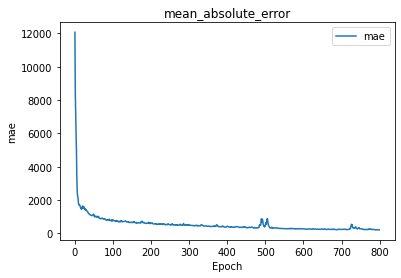

In [12]:
# 1.5.2 학습에 대한 mean_absolute_error 확인.
#plt.plot(np.asarray(hist.history['loss'])/1000)
plt.plot(hist.history['mae'])
plt.title('mean_absolute_error')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['mae'], loc='upper right')
plt.show()

In [13]:
# 1.5.3 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_x)
predit_y,predit_y.shape

(array([[19427.408  , 21786.068  , 22148.508  , ..., 23464.791  ,
         24226.947  , 23342.492  ],
        [21462.596  , 22254.11   , 20844.934  , ..., 23880.84   ,
         22942.588  , 22386.318  ],
        [22688.602  , 20911.04   , 20709.918  , ..., 23234.818  ,
         22256.186  , 22832.45   ],
        ...,
        [  681.2137 ,   596.0968 ,   599.5178 , ...,   545.5416 ,
           458.87537,   535.1237 ],
        [  675.30237,   561.5262 ,   590.84235, ...,   536.82544,
           471.78745,   533.35626],
        [  682.61664,   546.87164,   582.6313 , ...,   515.3985 ,
           450.18277,   499.0034 ]], dtype=float32), (137, 15))

In [14]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
predit = []
for forecast in range(forecast_days):
  predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))

a = pd.DataFrame(predit)
a

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19427.408203,21462.595703,22688.601562,20747.998047,20967.046875,22776.710938,23275.468750,22138.345703,21740.357422,22174.751953,...,1289.762695,1294.010986,1254.291382,1192.315430,1131.107788,1097.645752,1053.302734,1096.105957,1058.598267,1062.862793,990.952087,916.453735,865.617188,850.416260,828.057373,766.622864,733.199097,668.337708,633.276978,628.104187,627.021912,662.144653,680.570496,681.213684,675.302368,682.616638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21786.068359,22254.109375,20911.039062,20734.751953,23083.169922,22901.611328,22390.357422,21570.890625,21859.589844,...,1409.927490,1382.792969,1274.179077,1232.715576,1134.344727,1079.063721,1109.221069,1156.535034,1121.542725,1014.543640,990.460327,968.623535,931.024475,893.647034,861.099548,772.439087,738.680725,757.942505,728.708557,707.181030,664.806702,659.890991,623.135315,593.999878,596.096802,561.526184,546.871643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,22148.507812,20844.933594,20709.917969,22767.347656,23006.429688,22065.966797,21814.669922,21989.888672,...,1305.978516,1265.997559,1192.718018,1065.854126,979.878296,1018.448181,1070.959473,1080.157471,1061.970825,1020.347168,946.342957,918.248474,927.926392,900.204529,868.377136,822.144531,768.588379,724.499634,692.525391,658.012939,688.904480,720.294434,700.660706,642.716614,604.546875,599.517822,590.842346,582.631287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,20495.736328,21099.732422,22644.501953,22851.044922,22552.216797,21713.201172,21992.960938,...,1316.864990,1280.534424,1264.318237,1203.282593,1135.292725,1066.387207,1096.227173,1144.714355,1124.923340,1088.012329,1035.204590,981.271057,939.643494,908.418091,888.627930,858.533997,801.267029,760.635620,729.671204,696.104675,659.650635,679.337708,681.477722,685.389160,676.108826,674.191223,658.055786,661.225403,650.311768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,21363.666016,22995.794922,23619.490234,22619.070312,22166.134766,22074.449219,...,1320.629395,1242.270020,1190.545288,1116.636597,1085.737915,1076.650391,1052.786377,1011.264099,1000.587402,1024.663208,1031.424194,974.491943,936.810059,903.919556,841.159485,814.719299,803.249390,783.905457,752.702332,738.468201,750.866333,730.480774,707.662537,643.333984,683.332031,706.167725,723.094482,712.794739,693.408691,665.551392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,22938.853516,23377.109375,22219.921875,21946.917969,22178.453125,...,1467.004517,1385.194458,1369.873535,1293.791992,1213.110962,1173.623779,1145.378784,1110.567871,1085.192017,1067.90454

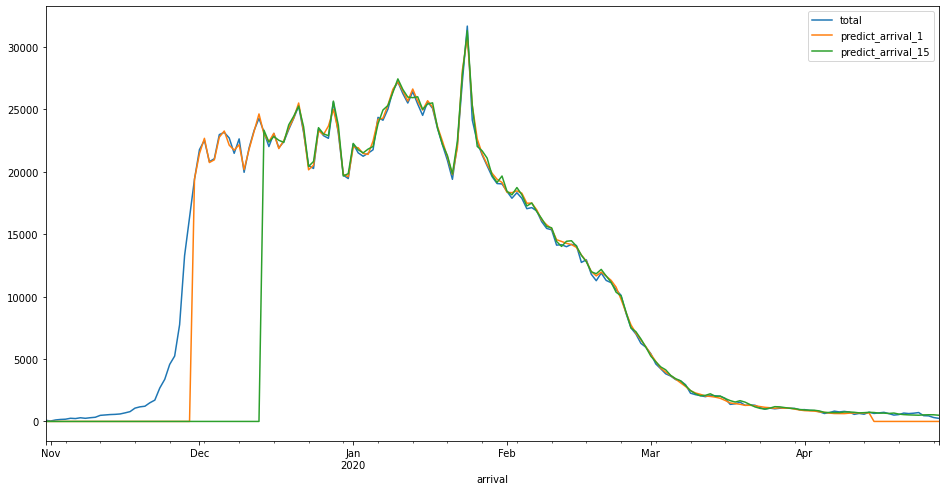

In [15]:
# 1.5.4 과거 Data에서 실등록자 count와 예측 count의 비교 

# 예측치를 chart에 같이 그려서 확인
comp_ds = raw_ds.copy()
comp_ds['predict_arrival_1'] = predit[0]
comp_ds['predict_arrival_15'] = predit[14]
comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))
# 예측치가 overfit 되어 보이기도...

In [16]:
# 1.6  향후 15일 예측
# 1.6.1 testset (마지막 30일)의 inference

# trainset의 마지막 날에서 15일까지의 예측
# 마지막 30일치 정보를 input으로...

test_x = test_x.reshape(-1,window,size)
predit_y = model.predict(test_x)
predit_y.shape

(1, 15)

In [17]:
# 1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

predic_ds = []
# 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
predit_y1 = predit_y * 100/24
from datetime import datetime, timedelta
last_date = raw_ds.index[-1]
print('============================================================')
for predict_count in predit_y1[0]:
  last_date += timedelta(days=1)
  print('Forecast of the number of immigrants on ' +str(last_date)[10]+ ':',int(predict_count))
  predic_ds.append({'date':last_date,'forecast':int(predict_count)})
print('============================================================')

predic_ds = pd.DataFrame(predic_ds)
predic_ds

Forecast of the number of immigrants on  : 1875
Forecast of the number of immigrants on  : 1868
Forecast of the number of immigrants on  : 1975
Forecast of the number of immigrants on  : 1901
Forecast of the number of immigrants on  : 1833
Forecast of the number of immigrants on  : 1638
Forecast of the number of immigrants on  : 1501
Forecast of the number of immigrants on  : 1489
Forecast of the number of immigrants on  : 1484
Forecast of the number of immigrants on  : 1476
Forecast of the number of immigrants on  : 1477
Forecast of the number of immigrants on  : 1542
Forecast of the number of immigrants on  : 1418
Forecast of the number of immigrants on  : 1215
Forecast of the number of immigrants on  : 1159


,date,forecast
0,2020-04-29,1875
1,2020-04-30,1868
2,2020-05-01,1975
3,2020-05-02,1901
4,2020-05-03,1833
5,2020-05-04,1638
6,2020-05-05,1501
7,2020-05-06,1489
8,2020-05-07,1484
9,2020-05-08,1476


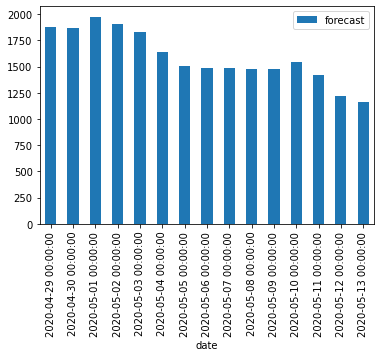

In [18]:
predic_ds.plot(x='date',y='forecast',kind='bar')

 2. Forecast with unstructured timeseries data<br>
  2.0 개요<br>
 	2.1 News Data의 load<br>
 	2.2 News Data에 대한 EDA<br>
 		2.2.1 게시일을 기준으로 News buzz의 합산
 		2.2.2 하루 최대 buzz count 추출
 		2.2.3 News buzz 추세 Chart
 	2.3 News Data의 전처리
		2.3.1 News Data의 doc2vec 처리
			2.3.1.1 document의 tokenize & tagging
			2.3.1.2 doc2vec model training
		2.3.4 원시(origin) Trainset의 구성
	2.4 doc2vec에 의한 Regression Test (Not forecast)
		2.4.1 doc2vec의 Timeseries model 구성
		2.4.2 원시(origin) Trainset으로 model training
		2.4.3 학습에 대한 mean_absolute_error 확인.
		2.4.4 trainset에 의한 과거 data의 예측 입국자 count 
		2.4.5 실등록자 count와 news기반 예측 count의 비교 chart
	2.5 doc2vec에 의한 Forecast regression
		2.5.1 doc2vec의 Window 적용 Timeseries Trainset의 구성
		2.5.2 doc2vec Window 의 Timeseries model 구성
		2.5.3 doc2vec의 Window 적용 Timeseries Trainset으로 model training
		2.5.4 학습에 대한 mean_absolute_error 확인.
		2.5.5 trainset에 의한 과거 data의 예측 입국자 추정 
		2.5.6 실등록자 count와 news기반 예측 count의 비교 chart
 	2.6  향후 15일 예측
 		2.6.1 testset (마지막 30일)의 inference
 		2.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출


2.0 Forecast with unstructured timeseries data의 개요
 <br>corona 관련 news가 입국자에 어떻게 영향을 주었는지 분석하기 위해서는 news의 내용을 알아야 하고 labeling 의 과정이
 사람에 의해 이루어 져야 하나, 그럴 공수는 들이지 못하므로, doc2vec을 활용하여 news를 vector화 하고 이를 입국자수에 대해 regression한다.
 <br>news vector는 하루의 최대 뉴스수를 기준으로 Metrics를 만든다.
 EDA과정에 의해 corona로 분류된 뉴스는 하루 최대 1948, 이며 document의 vector 사이즈는 임으로 40을 정했다. 
 <br>자원의 활용상 news의 title만 vector화 하였다. 만약, contents 를 vector화 한다면 vector sizr를 400~1000으로 충분히 크게 잡으면 될 것이고,
 전체적인 과정 및 알고리즘은 동일하다.
<br><br>
 즉, 전체 분석 알고리즘은 
 분석대상 날짜수 (=로밍데이터와 동일한 날자수) 약 181일, 따라서 전체 metric은 (181,1948,40) 
 <br>이것을 시계열로 학습해서 예측을 하기 위해서는 로밍등록자 예측과 유사하게 30일 window로 15일을 예측하도록 한다.
 <br>따라서 학습셋(train_news_x)의 최종 shape은 (136,30,1948,40) 이될것.. train_news_y 는 (136,15)...
 <br>train_news_x (136,30,1948,40) -> convolutional regression to train_news_y (136,15)


In [0]:

# 	2.1 News Data의 load

# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns =pd.concat([ns1, ns2], ignore_index=True, sort=False)

In [20]:
ns

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
103822,XWFB2020040900020,"Ching Ming remembrance, home country forever! ...",http://wsjkw.sh.gov.cn/xwfb/20200404/2f54e0e14...,2020-04-09 16:05:21.0,2020-04-04 00:00:00,Shanghai Municioal Health Commission,COVID-19,Viral
103823,ZWYW2020041000002,Guangdong Provincial Health Commission notifie...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-10 18:00:45.0,2020-04-10 00:00:00,Health Commission of Guangdong Province,Dengue fever,Viral
103824,ZWYW2020041500002,Guangdong Provincial Health Commission announc...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:04.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral
103825,ZWYW2020041500003,Guangdong Provincial Health Commission release...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:13.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral


In [21]:
# 	2.2 News Data에 대한 EDA
# 		2.2.1 게시일을 기준으로 News buzz의 합산

cov_news = ns.loc[ns['감염병명'] == 'COVID-19']
cov_news['게시일자'] =  cov_news['게시일자'].str[:10]
cov_buz = pd.DataFrame(cov_news.groupby('게시일자')['감염병명'].count())
cov_buz = cov_buz.loc[cov_buz.index >= '2019-10-31']
cov_buz['date'] = pd.to_datetime(cov_buz.index, format='%Y-%m-%d')
cov_buz = cov_buz.rename(columns={"감염병명":"buz_count"})
cov_buz

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,buz_count,date
게시일자,,
2019-12-01,1,2019-12-01
2019-12-14,2,2019-12-14
2019-12-30,3,2019-12-30
2019-12-31,5,2019-12-31
2020-01-02,1,2020-01-02
...,...,...
2020-04-26,1176,2020-04-26
2020-04-27,1353,2020-04-27
2020-04-28,999,2020-04-28


In [22]:
# 		2.2.2 하루 최대 buzz count 추출

max_buz_per_day = cov_buz['buz_count'].max()
max_buz_per_day

1948

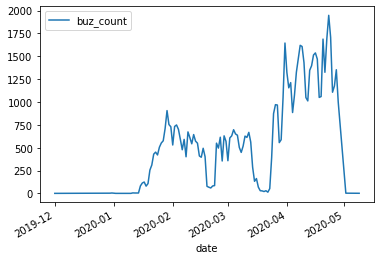

In [23]:
# 		2.2.3 News buzz 추세 Chart

cov_buz.plot(x='date',y='buz_count')

In [24]:
# 	2.3 News Data의 전처리
#		2.3.1 News Data의 doc2vec 처리

!pip install nltk
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
#			2.3.1.1 document의 tokenize & tagging
# 실 Contents는 사용하지 않고 title만 doc2vec 처리...
tagged_data = []
for row in cov_news.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    tagged_data.append(TaggedDocument(words=word_tokenize(title.lower()), tags=[file_name]))
    
len(tagged_data)

73752

In [27]:
#			2.3.1.2 doc2vec model training
# 시간 무지 걸림... 돌리고 커피 한잔 마시기.

max_epochs = 10 # 이건 나중에 100 정도로 수정...
vec_size = 40
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")

print("Model Saved")

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


In [31]:
# doc2vec 모델 학습 결과 확인..
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['AFRO2020013100001'])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[ 0.6442611  -0.53671753  1.2004722  -0.5717443   0.5683985  -0.1764215
 -1.019586    0.91261685  0.7194078   0.09687414 -0.48264655 -0.31238866
 -0.15888818 -0.5280081  -0.8786781   1.5205582   0.5434704  -0.39503998
  0.91762304  1.8859266  -0.257847   -0.8021391  -0.50667876 -0.46430254
 -1.3436102   0.39511138  0.17286897 -1.29504     0.10404196 -0.87494266
  0.8843639   0.31994936 -0.66550803 -0.35284173 -0.6671661  -0.94385856
 -0.672377   -0.81298226  0.8602634  -0.9028348 ]


In [28]:
#		2.3.4 원시(origin) Trainset의 구성

# doc2vec을 feature로 하는 원시 학습셋을 구성한다.
# 이때, 입국일자을 기준으로 Set을 만드는데...
# 입국일에 news가 없을 때도 있어서, 일관성 있는 양질의 학습셋이 되기는 어려울 듯...
# 준대로 해야지 어쩔 수 없음.

cov_news['게시일자'] = pd.to_datetime(cov_news['게시일자'], format='%Y-%m-%d')
news_metric = []
from datetime import datetime, timedelta
import numpy as np
# 날짜별 (1948,40) 구성
for row in ar.iterrows():
    date = row[1][1]#datetime(2019,12,31)
    selected_ns = cov_news.loc[cov_news['게시일자'] >= date].loc[cov_news['게시일자'] < (date + timedelta(days=1))]
    #print(date,selected_ns.shape)
    if selected_ns.shape[0] == 0:
        # news가 없는 경우..
        news_metric.append(np.zeros((max_buz_per_day,vec_size)))
    else:
        docv = []
        for nrow in selected_ns.iterrows():
            #print('tag name:',nrow[1][0])
            docv.append(model.docvecs[nrow[1][0]])
        for i in range(max_buz_per_day-selected_ns.shape[0]):
            docv.append(np.zeros(vec_size))
        news_metric.append(docv)
        
train_temp_x = np.asarray(news_metric)
train_temp_x.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(181, 1948, 40)

In [29]:
# 학습셋의 내용 확인...
train_temp_x[162]

array([[-0.00461525,  0.51610649,  0.1665802 , ...,  0.66348994,
        -0.86093056, -0.54782838],
       [ 0.66517526,  0.38851291, -0.15331669, ...,  0.15475358,
        -0.03792915,  0.29880318],
       [ 0.45754144, -0.21341427, -0.50959063, ...,  0.6096741 ,
        -0.14223522,  0.29804918],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [30]:
# 학습셋의 label... 원시 train_temp_y의 구성
train_temp_y = np.asanyarray(ar['count'])
train_temp_y.shape
                                   

(181,)

In [31]:
#	2.4 doc2vec에 의한 Regression Test (Not forecast)
#		2.4.1 doc2vec의 Timeseries model 구성

# 일단, news regression의 설명력을 확인하기 위해...원시 학습을 test 한다.
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,2, input_shape=(max_buz_per_day,vec_size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1948, 128)         10368     
_________________________________________________________________
activation_5 (Activation)    (None, 1948, 128)         0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 974, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 974, 64)           16448     
_________________________________________________________________
activation_6 (Activation)    (None, 974, 64)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 487, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 487, 32)          

In [32]:
#		2.4.2 원시(origin) Trainset으로 model training

hist = model.fit(train_temp_x, train_temp_y, epochs=1000,verbose=1)

Epoch 1/1000
181/181 [==============================] - 1s 3ms/step - loss: 218062078.4972 - mae: 10875.3574
Epoch 2/1000
181/181 [==============================] - 0s 1ms/step - loss: 215755687.7790 - mae: 10714.8574
Epoch 3/1000
181/181 [==============================] - 0s 1ms/step - loss: 209458936.4862 - mae: 10749.6572
Epoch 4/1000
181/181 [==============================] - 0s 1ms/step - loss: 201146132.7735 - mae: 10965.7344
Epoch 5/1000
181/181 [==============================] - 0s 1ms/step - loss: 191910780.5083 - mae: 10899.2256
Epoch 6/1000
181/181 [==============================] - 0s 1ms/step - loss: 182309464.3094 - mae: 10562.8760
Epoch 7/1000
181/181 [==============================] - 0s 1ms/step - loss: 172648461.3481 - mae: 10451.6670
Epoch 8/1000
181/181 [==============================] - 0s 1ms/step - loss: 160416749.9669 - mae: 10208.5332
Epoch 9/1000
181/181 [==============================] - 0s 1ms/step - loss: 147121468.2873 - mae: 9792.0791
Epoch 10/1000
181/18

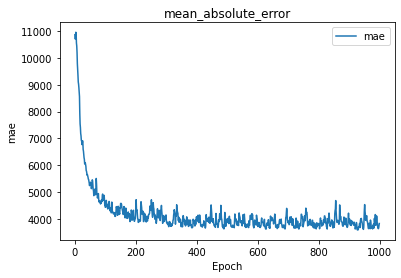

In [34]:
#		2.4.3 학습에 대한 mean_absolute_error 확인.

plt.plot(hist.history['mae'])
plt.title('mean_absolute_error')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['mae'], loc='upper right')
plt.show()

In [0]:
#		2.4.4 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_temp_x)
predit = predit_y.reshape(predit_y.shape[0])

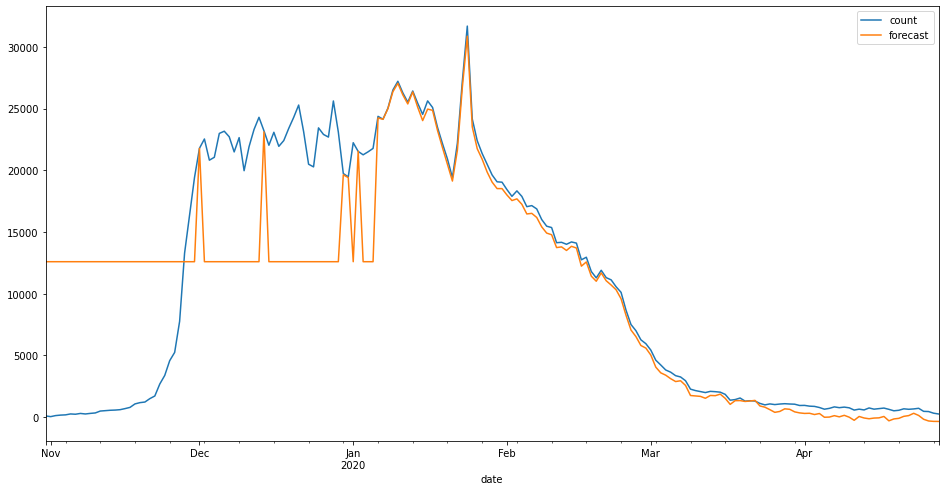

In [37]:
#		2.4.5 실등록자 count와 news기반 예측 count의 비교 chart
predit_result = ar.copy()
predit_result['forecast'] = predit
predit_result.plot(x='date',y=['count','forecast'],figsize=(16,8))

In [38]:
# 오~ 그래도, 뉴스 버즈량이 많은 구간에서는 입국자수가 어느정조 설명되는 듯..
# 이제는 window를 적용해서 예측 모델을 만들어야 함.
train_temp_y[0]

91

In [0]:
#	2.5 doc2vec에 의한 Forecast regression
#		2.5.1 doc2vec의 Window 적용 Timeseries Trainset의 구성

# window를 30일로 설정 -> 그냥 잡은 수치
news_window = 30
#향후 15일 예측
news_forecast_days = 15

# 원시 trainset의 사용...
train_news_org_y = train_temp_y
data = train_temp_x

train_news_x = []
train_news_y = []

for i in range(data.shape[0]-news_window-news_forecast_days + 1):
    sub_x = []
    for j in range(news_window):
        sub_x.append(data[i+j,:,:])
    train_news_x.append(sub_x)

    sub_y = []
    for z in range(news_forecast_days):
        sub_y.append(train_news_org_y[i + news_window + z])
    train_news_y.append(sub_y)

#train_news_x ,train_news_y 준비
train_news_x = np.asarray(train_news_x)
train_news_x = train_news_x.reshape(-1,news_window,max_buz_per_day,vec_size)
train_news_y = np.asarray(train_news_y)

test_news_x = data[data.shape[0]-news_window:data.shape[0],:,:]

In [40]:
#train_news_x ,train_news_y (사실이거는 그냥 train_y와 동일...)의 내용 확인.
train_news_x, train_news_x.shape, train_news_y, train_news_y.shape, test_news_x, test_news_x.shape

(array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          ...,
          [ 0

In [80]:
#		2.5.2 doc2vec Window 의 Timeseries model 구성

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(128,(3,3), input_shape=(news_window,max_buz_per_day,vec_size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(2,2),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(2,2),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(0.1))
model.add(Dense(news_forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 1948, 128)     46208     
_________________________________________________________________
activation_28 (Activation)   (None, 30, 1948, 128)     0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 974, 128)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 974, 64)       32832     
_________________________________________________________________
activation_29 (Activation)   (None, 15, 974, 64)       0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 487, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 487, 32)       

In [81]:
#		2.5.3 doc2vec의 Window 적용 Timeseries Trainset으로 model training

# 로밍등록자 수와 직접적인 상관관계가 적은 news 정보 이므로 overfit 될 가능성 큼, dropout 넣어 overfit 예방...
hist = model.fit(train_news_x, train_news_y, epochs=30,verbose=1)

Epoch 1/30
137/137 [==============================] - 3s 25ms/step - loss: 259645092.0876 - mae: 12737.7432
Epoch 2/30
137/137 [==============================] - 3s 23ms/step - loss: 253114743.1241 - mae: 12392.2100
Epoch 3/30
137/137 [==============================] - 3s 23ms/step - loss: 247791515.5620 - mae: 13099.0674
Epoch 4/30
137/137 [==============================] - 3s 23ms/step - loss: 238756625.4015 - mae: 12382.6836
Epoch 5/30
137/137 [==============================] - 3s 23ms/step - loss: 230796155.6788 - mae: 12076.0791
Epoch 6/30
137/137 [==============================] - 3s 23ms/step - loss: 213515344.5839 - mae: 12021.7959
Epoch 7/30
137/137 [==============================] - 3s 23ms/step - loss: 182789598.4818 - mae: 11103.1035
Epoch 8/30
137/137 [==============================] - 3s 23ms/step - loss: 121153056.2336 - mae: 8958.5576
Epoch 9/30
137/137 [==============================] - 3s 23ms/step - loss: 50019398.0292 - mae: 6027.3320
Epoch 10/30
137/137 [==========

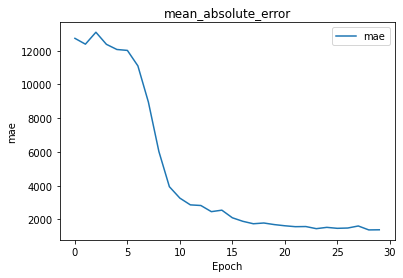

In [82]:
#		2.5.4 학습에 대한 mean_absolute_error 확인.

plt.plot(hist.history['mae'])
plt.title('mean_absolute_error')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['mae'], loc='upper right')
plt.show()

In [83]:
#		2.5.5 trainset에 의한 과거 data의 예측 입국자 추정 

predit_news_y = model.predict(train_news_x)
predit_news_y,predit_news_y.shape

(array([[23529.7    , 23517.547  , 23338.451  , ..., 22576.582  ,
         22314.428  , 22200.295  ],
        [23529.7    , 23517.547  , 23338.451  , ..., 22576.582  ,
         22314.428  , 22200.295  ],
        [23536.387  , 23524.094  , 23344.834  , ..., 22581.096  ,
         22318.81   , 22204.332  ],
        ...,
        [ 1473.3201 ,  1507.5327 ,  1326.5436 , ...,  1955.4497 ,
          1890.1412 ,  1971.5165 ],
        [ 1134.8331 ,  1188.4423 ,  1010.1222 , ...,  1716.0728 ,
          1657.24   ,  1753.5837 ],
        [  541.01697,   587.7756 ,   406.84915, ...,  1113.1046 ,
          1059.7787 ,  1181.7065 ]], dtype=float32), (137, 15))

In [84]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
predit_news = []
for forecast in range(news_forecast_days):
  predit_news.append(list(np.concatenate((np.zeros(news_window+ forecast), predit_news_y[:,forecast],np.zeros(news_forecast_days-forecast-1)), axis=0)))

b = pd.DataFrame(predit_news)
b

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23529.699219,23529.699219,23536.386719,23540.796875,23540.447266,23543.636719,23545.603516,23547.501953,23545.669922,23548.673828,...,1377.672974,1080.533203,1173.099243,1511.076416,2165.850586,2823.924561,2988.354980,2711.604248,2804.175293,2865.437012,2952.035645,2855.793213,1123.604004,1193.326660,1556.894043,503.288239,157.304535,-531.493774,-168.613541,-137.310516,-215.930878,397.922913,1111.462402,1473.320068,1134.833130,541.016968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,23517.546875,23517.546875,23524.093750,23528.484375,23528.134766,23531.306641,23533.277344,23535.156250,23533.333984,...,1030.070312,1003.275574,702.306091,796.926819,1147.282837,1807.756836,2474.073242,2645.079346,2377.858398,2470.958496,2522.278320,2608.001953,2526.068359,847.798096,939.227661,1315.260254,293.550171,-43.772373,-734.856934,-364.274200,-264.264404,-283.652435,369.356842,1105.258301,1507.532715,1188.442261,587.775574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,23338.451172,23338.451172,23344.833984,23349.109375,23348.751953,23351.796875,23353.710938,23355.574219,...,852.603577,658.841919,640.374512,346.280182,448.615417,819.817993,1494.045532,2175.244629,2355.890625,2098.084961,2182.461426,2221.091064,2298.200195,2227.288330,592.428528,693.615540,1072.120850,77.307549,-256.844421,-947.562256,-584.203064,-452.304382,-456.987671,191.128021,915.119751,1326.543579,1010.122192,406.849152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,23353.162109,23353.162109,23359.363281,23363.501953,23363.164062,23366.113281,23367.984375,...,1029.356079,762.421082,580.363831,567.763672,281.594818,390.635742,777.081421,1460.584351,2150.818848,2341.458496,2095.440918,2174.253418,2201.965820,2272.638916,2212.150146,631.067627,750.102722,1134.003174,178.565964,-148.798920,-833.818848,-474.997711,-303.458710,-283.138672,359.431152,1074.571045,1499.764282,1196.573364,593.798157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,23275.033203,23275.033203,23281.058594,23285.039062,23284.708984,23287.585938,...,1987.848389,765.743530,503.231384,328.705841,316.591217,29.138815,140.697266,535.196777,1224.155029,1917.216797,2122.799072,1893.301270,1973.619263,1996.591675,2066.757812,2026.176514,506.099884,645.711304,1038.198364,116.579826,-200.519409,-884.253296,-526.461609,-302.019226,-240.385086,427.793640,1147.267334,1594.210449,1298.130127,687.895630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,23055.220703,23055.220703,23061.142578,23065.123047,23064.791016,...,1986.818237,1701.300537,490.513062,233.961304,63.529476,51.830948,-232.907257,

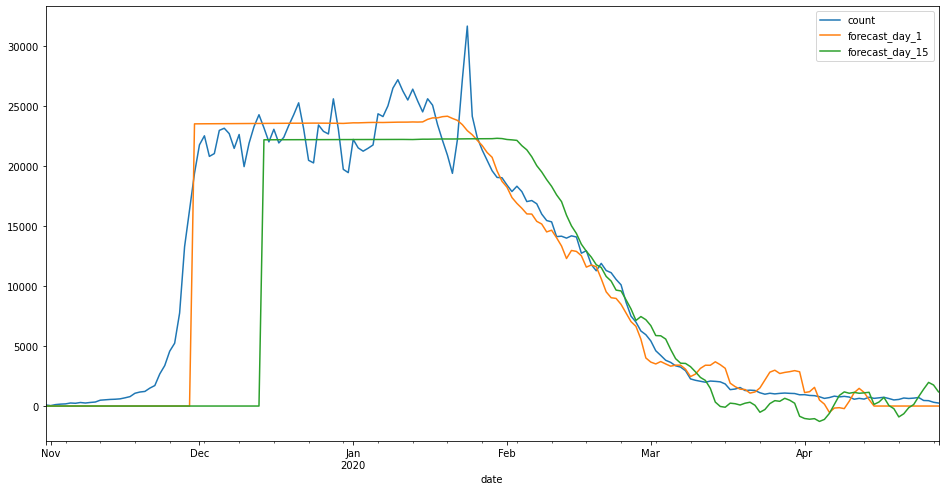

In [85]:
#		2.5.6 실등록자 count와 news기반 예측 count의 비교 chart

predit_result = ar.copy()
predit_result['forecast_day_1'] = predit_news[0]
predit_result['forecast_day_15'] = predit_news[14]
predit_result.plot(x='date',y=['count','forecast_day_1','forecast_day_15'],figsize=(16,8))


In [86]:
# 	2.6  향후 15일 예측
# 		2.6.1 testset (마지막 30일)의 inference

test_news_x = test_news_x.reshape(-1,news_window,max_buz_per_day,vec_size)
predit_y = model.predict(test_news_x)
predit_y,predit_y.shape

(array([[44297.57 , 44208.82 , 43759.887, 43820.816, 43647.1  , 43168.367,
         43001.45 , 42707.723, 42829.215, 42663.44 , 42944.992, 42952.805,
         42201.684, 41634.484, 41465.684]], dtype=float32), (1, 15))

In [87]:
# 		2.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

predic_ds = []
# 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
predit_y1 = predit_y * 100/24
from datetime import datetime, timedelta
last_date = raw_ds.index[-1]
print('============================================================')
for predict_count in predit_y1[0]:
  last_date += timedelta(days=1)
  print('Forecast of the number of immigrants on ' +str(last_date)[10]+ ':',int(predict_count))
  predic_ds.append({'date':last_date,'forecast':int(predict_count)})
print('============================================================')

predic_ds = pd.DataFrame(predic_ds)
predic_ds

Forecast of the number of immigrants on  : 184573
Forecast of the number of immigrants on  : 184203
Forecast of the number of immigrants on  : 182332
Forecast of the number of immigrants on  : 182586
Forecast of the number of immigrants on  : 181862
Forecast of the number of immigrants on  : 179868
Forecast of the number of immigrants on  : 179172
Forecast of the number of immigrants on  : 177948
Forecast of the number of immigrants on  : 178455
Forecast of the number of immigrants on  : 177764
Forecast of the number of immigrants on  : 178937
Forecast of the number of immigrants on  : 178970
Forecast of the number of immigrants on  : 175840
Forecast of the number of immigrants on  : 173477
Forecast of the number of immigrants on  : 172773


,date,forecast
0,2020-04-29,184573
1,2020-04-30,184203
2,2020-05-01,182332
3,2020-05-02,182586
4,2020-05-03,181862
5,2020-05-04,179868
6,2020-05-05,179172
7,2020-05-06,177948
8,2020-05-07,178455
9,2020-05-08,177764


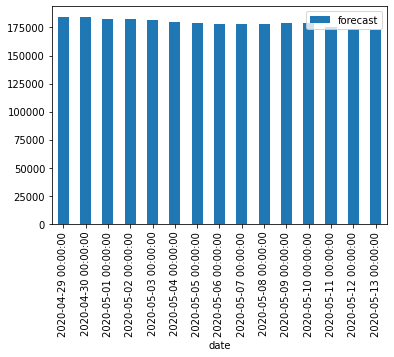

In [88]:
predic_ds.plot(x='date',y='forecast',kind='bar')

이유는 모르겠으나.. 입국자 엄청 많은걸로 나옴...
<br>모르겠음. flow는 틀린거 같지 않은데...
<br>news에 5월 초,중 한국이 많이 극복하면서 입국자가 늘어날 것이다 라는 내용이 있을 수는 있겠으나... 그걸 인식하지는 못 했을 듯 한데...
<br>뭔가 잘 못 된 것 같음...

 3. Forecast with combined numeric timeseries and unstructured timeseries <br>
	3.1 개요<br>
	3.2 Numeric timeseries and unstructured timeseries combined model 구성<br>
	3.3 Numeric timeseries and unstructured timeseries data train
		3.3.1 학습에 대한 mean_absolute_error 확인.
		3.3.2 trainset에 의한 과거 data의 예측 입국자 count 
		3.3.3 실등록자 count와 news기반 예측 count의 비교 chart
 	3.4  향후 15일 예측
 		3.4.1 testset (마지막 30일)의 inference
 		3.4.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출
	3.5 최종 결과

3.1 개요<br>

 마지막으로 Roaming trainset의 1D Convolution과 News doc2vec trainset의 2D Convolution을 합성하여 하나의 모델로 만들고 두개의 trainset으로 학습하여 미래 15일을 예측한다.
 <br><br>Keras: Multiple Inputs and Mixed Data<br>
https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [89]:
#	3.2 Numeric timeseries and unstructured timeseries combined model 구성

from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate

# define two sets of inputs
input_roaming = Input(shape=(window, size))
input_news = Input(shape=(news_window,max_buz_per_day,vec_size))

# 로밍등록자에 대한 1D Convilution layer 구성
x = Conv1D(128,4, activation="relu",padding="same")(input_roaming)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(32,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Model(inputs=input_roaming, outputs=x)


# news에 대한 2D Convolution layer 구성
y = Conv2D(128,(3,3), activation="relu",padding="same")(input_news)
y = MaxPooling2D(pool_size=(2,2))(y)
y = Conv2D(64,(2,2), activation="relu",padding="same")(y)
y = MaxPooling2D(pool_size=(2,2))(y)
y = Conv2D(32,(2,2), activation="relu",padding="same")(y)
y = MaxPooling2D(pool_size=(2,2))(y)
y = Flatten()(y)
y = Model(inputs=input_news, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(1024, activation="relu")(combined)
z = Dropout(0.05)(z)
z = Dense(forecast_days, activation="linear")(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 174)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30, 1948, 40) 0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 30, 128)      89216       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 30, 1948, 128 46208       input_2[0][0]                    
____________________________________________________________________________________________

In [90]:
#	3.3 Numeric timeseries and unstructured timeseries data train

# 어떨지 모르니 일단 epoch 100으로
hist = model.fit([train_x,train_news_x], train_y, epochs=100,verbose=1)

Epoch 1/100
137/137 [==============================] - 3s 25ms/step - loss: 241916897.0511 - mae: 12191.0801
Epoch 2/100
137/137 [==============================] - 3s 23ms/step - loss: 126587628.8467 - mae: 8801.8340
Epoch 3/100
137/137 [==============================] - 3s 23ms/step - loss: 72737657.9562 - mae: 6806.2563
Epoch 4/100
137/137 [==============================] - 3s 23ms/step - loss: 80005297.5766 - mae: 6614.3096
Epoch 5/100
137/137 [==============================] - 3s 23ms/step - loss: 57300678.0730 - mae: 6025.1631
Epoch 6/100
137/137 [==============================] - 3s 22ms/step - loss: 47266306.5985 - mae: 5434.3213
Epoch 7/100
137/137 [==============================] - 3s 22ms/step - loss: 30941841.9270 - mae: 3916.2158
Epoch 8/100
137/137 [==============================] - 3s 23ms/step - loss: 19126937.3431 - mae: 3052.5540
Epoch 9/100
137/137 [==============================] - 3s 23ms/step - loss: 13754380.0967 - mae: 2381.3538
Epoch 10/100
137/137 [============

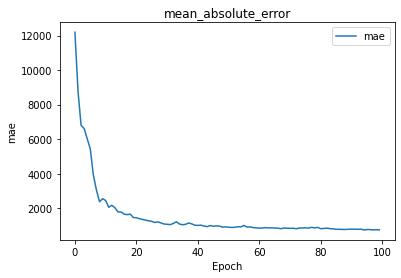

In [91]:
#		3.3.1 학습에 대한 mean_absolute_error 확인.

plt.plot(hist.history['mae'])
plt.title('mean_absolute_error')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['mae'], loc='upper right')
plt.show()

In [92]:
#		3.3.2 trainset에 의한 과거 data의 예측 입국자 count 

predit_y = model.predict([train_x,train_news_x])
predit_y,predit_y.shape

(array([[19992.361  , 20940.271  , 20982.795  , ..., 22187.715  ,
         22188.76   , 21959.97   ],
        [21767.445  , 22694.162  , 22823.287  , ..., 23965.36   ,
         23942.66   , 23787.361  ],
        [21849.7    , 22638.22   , 22867.512  , ..., 23781.09   ,
         23730.098  , 23720.36   ],
        ...,
        [  484.2409 ,   435.2642 ,   494.18384, ...,   648.8247 ,
           446.09952,   242.63066],
        [  507.075  ,   509.24536,   531.8878 , ...,   528.5233 ,
           349.52823,   125.53461],
        [  602.9608 ,   556.65826,   542.3786 , ...,   459.88007,
           301.33228,   106.32843]], dtype=float32), (137, 15))

In [93]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
predit = []
for forecast in range(forecast_days):
  predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))

a = pd.DataFrame(predit)
a

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19992.361328,21767.445312,21849.699219,21631.962891,21644.644531,21643.960938,21967.349609,22151.294922,22514.439453,22396.214844,...,1232.947510,1232.771240,1033.967651,955.530334,878.683899,991.562012,1091.070679,1072.062134,953.471619,894.492920,917.618835,834.474121,738.790833,854.655457,799.203247,661.810120,604.872375,607.288452,627.156799,639.842163,657.868286,589.862549,528.620117,484.240906,507.075012,602.960815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,20940.271484,22694.162109,22638.220703,22298.013672,22204.308594,22106.837891,22281.253906,22423.302734,22771.474609,...,1220.577271,1117.042603,1127.052856,952.046875,870.634277,772.990356,940.147949,1166.285645,1111.295288,874.708069,824.730896,905.307678,832.164062,664.877441,731.653931,650.984863,540.537415,526.453186,557.168091,570.769653,582.716370,598.333008,523.624878,494.867767,435.264191,509.245361,556.658264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,20982.794922,22823.287109,22867.511719,22495.177734,22273.041016,22091.488281,22266.496094,22531.703125,...,1208.090210,1185.416992,1085.307007,1094.707397,938.666565,883.547546,788.751465,886.971924,1095.843140,1109.009033,894.990723,830.472168,892.854187,830.009705,607.441772,643.239685,590.127869,590.425354,618.252014,623.712219,627.549011,520.438416,497.820801,451.561920,424.172333,494.183838,531.887817,542.378601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,20683.466797,22509.679688,22559.630859,22202.052734,21993.085938,21840.097656,22083.515625,...,1326.935181,1161.366821,1145.994385,1065.886475,1056.721436,941.969910,941.610962,883.316589,831.054871,919.646179,963.084045,883.763794,835.581543,857.353455,785.541748,609.423340,629.072876,646.985962,647.562622,663.516479,690.255432,659.306152,557.850342,584.942322,568.746765,581.943176,562.859009,555.895996,511.365082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,20661.298828,22409.371094,22366.203125,21993.929688,21772.927734,21645.408203,...,1379.478271,1332.383179,1194.090942,1187.708008,1138.400635,1142.702759,1045.105713,1088.350098,1057.383545,911.870911,957.542542,906.994263,862.629333,859.302307,849.459961,759.392761,678.542175,692.533081,696.194702,675.016113,653.121582,608.508057,574.271118,566.634338,608.874634,570.580994,560.815125,608.414185,619.613647,516.543030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,21424.728516,23114.843750,22928.384766,22492.033203,22241.617188,...,1323.765991,1292.223999,1277.021484,1171.576782,1185.393066,1183.001465,1188.898071,1083.902344,1077.507568,1031.647461,938.191895,990.770325,98

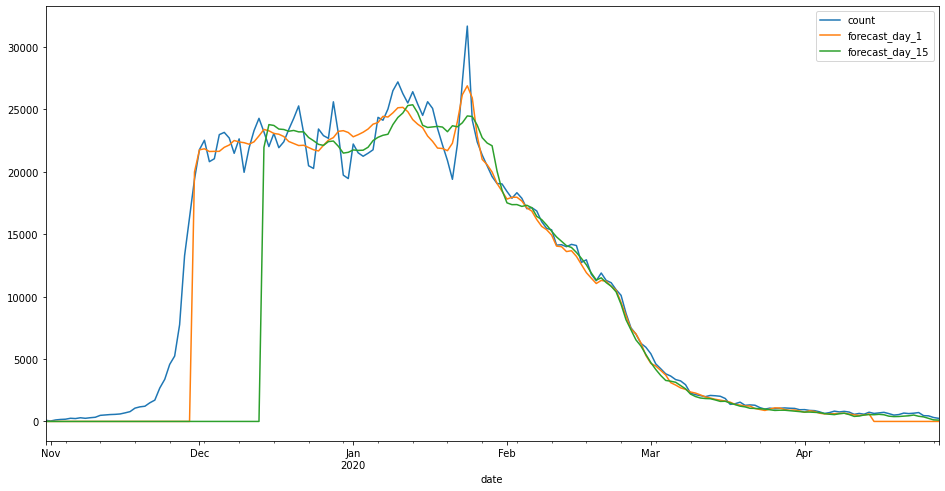

In [94]:
#		3.3.3 실등록자 count와 news기반 예측 count의 비교 chart

predit_result = ar.copy()
predit_result['forecast_day_1'] = predit[0]
predit_result['forecast_day_15'] = predit[14]
predit_result.plot(x='date',y=['count','forecast_day_1','forecast_day_15'],figsize=(16,8))

In [95]:
# 	3.4  향후 15일 예측
# 		3.4.1 testset (마지막 30일)의 inference

predit_y = model.predict([test_x,test_news_x])
predit_y,predit_y.shape

(array([[ 8533.466 , 10971.136 , 10694.217 ,  9508.466 ,  9467.036 ,
         11005.8125,  9091.543 ,  8529.677 ,  8485.7   ,  9696.412 ,
          8873.241 ,  9822.868 , 10741.104 , 11288.583 , 11232.462 ]],
       dtype=float32), (1, 15))

In [96]:
# 		3.4.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출
# 험난한 분석의 마지막 결과...

predic_ds = []
# 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
predit_y1 = predit_y * 100/24
from datetime import datetime, timedelta
last_date = raw_ds.index[-1]
print('============================================================')
for predict_count in predit_y1[0]:
  last_date += timedelta(days=1)
  print('Forecast of the number of immigrants on ' +str(last_date)[10]+ ':',int(predict_count))
  predic_ds.append({'date':last_date,'forecast':int(predict_count)})
print('============================================================')

predic_ds = pd.DataFrame(predic_ds)
predic_ds


Forecast of the number of immigrants on  : 35556
Forecast of the number of immigrants on  : 45713
Forecast of the number of immigrants on  : 44559
Forecast of the number of immigrants on  : 39618
Forecast of the number of immigrants on  : 39445
Forecast of the number of immigrants on  : 45857
Forecast of the number of immigrants on  : 37881
Forecast of the number of immigrants on  : 35540
Forecast of the number of immigrants on  : 35357
Forecast of the number of immigrants on  : 40401
Forecast of the number of immigrants on  : 36971
Forecast of the number of immigrants on  : 40928
Forecast of the number of immigrants on  : 44754
Forecast of the number of immigrants on  : 47035
Forecast of the number of immigrants on  : 46801


,date,forecast
0,2020-04-29,35556
1,2020-04-30,45713
2,2020-05-01,44559
3,2020-05-02,39618
4,2020-05-03,39445
5,2020-05-04,45857
6,2020-05-05,37881
7,2020-05-06,35540
8,2020-05-07,35357
9,2020-05-08,40401


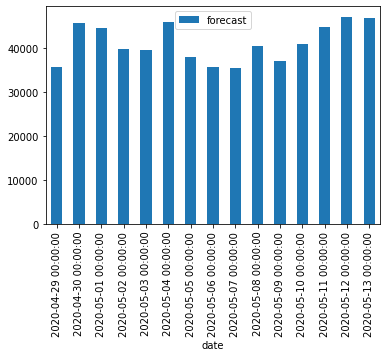

In [97]:
predic_ds.plot(x='date',y='forecast',kind='bar')

3.5 최종 결과<br>
 내용적으로 봤을때 로밍정보와 뉴스 정보가 적절히 썩여서 결과가 나온것으로 보인다.<br>
 예측력이 그리 좋지는 않겠지만 이는 뉴스 정보가 일관적으로 수집되지 않아서 이지 않을까 생각됨...<br>
 하지만 분석의 방법론 및 알고리즘의 구성 만큼은 적정할 것이라 판담함.<br>
<br>
 이상으로 험난한 코로나에 대한 입국자 추정 분석을 마침.
<br>
 2020.05.02 18:25 이훈석